In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
%matplotlib inline

In [2]:
data_genres = pd.read_csv('data_genres.csv')
data_genres.drop('Unnamed: 0', axis=1, inplace=True)
me = pd.read_csv('400000.csv')

In [3]:
me['label'] = 1
data_genres_me = pd.merge(data_genres, me[['anime_id', 'label']], how='left', on='anime_id')
data_genres_me = data_genres_me.fillna(0)
data_genres_me.head(3)

,Demons,Shounen,Kids,Parody,Magic,Sports,Action,Adventure,Thriller,Samurai,...,School,Space,Military,Fantasy,Super Power,Josei,Comedy,Music,anime_id,label
0,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,1,0.0
1,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,5,0.0
2,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,1,0,6,0.0


Кумулятивная доля дисперсии по компонентам [  5.61547176  10.45545613  14.73863658  18.7911339   22.29592093
  25.61454657  28.76765486  31.62924957  34.43035396  37.16685645
  39.76752327  42.28352404  44.7598828   47.15227597  49.50766086
  51.83148582  54.13549809  56.41670505  58.66123055  60.88226335
  63.05813892  65.20828082  67.30024442  69.30362534  71.29701063
  73.18712719  75.05028497  76.87643915  78.65949632  80.38844045
  82.09277851  83.75439001  85.39695168  86.9648351   88.51876579
  90.01250431  91.49246035  92.87639066  94.2169852   95.53382531
  96.83217035  98.02692349  99.1506265  100.        ]


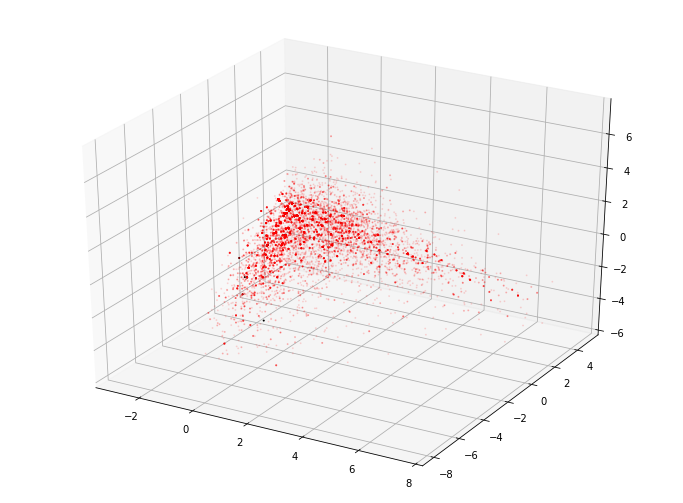

In [4]:
X_ = data_genres_me
label = np.array(data_genres_me['label'])
X_ = X_.drop(['anime_id', 'label'], axis=1)
X_ = X_.reset_index(drop=True)
X_ = X_.astype(float)
X_ = np.array(X_)
# Для начала отмасштабируем выборку
rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по столбцу
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]
        
# Найдем собственные векторы и собственные значения (англ. Eigenvalues)
covariance_matrix = X_.T.dot(X_)
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)    
eig_sum = sum(eig_values)
# Доля дисперсии, описываемая каждой из компонент
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
# Кумулятивная доля дисперсии по компонентам
cum_var_exp = np.cumsum(var_exp)
print('Кумулятивная доля дисперсии по компонентам', cum_var_exp)
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(cols,1), eig_pairs[1][1].reshape(cols,1), eig_pairs[2][1].reshape(cols,1)))
# print(f'Матрица весов W:\n', W)
Z = X_.dot(W)
y = label

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(111, projection='3d')

for c, i, s, t in zip("rk", [0, 1], [1, 1], [0.1, 1]):
    ax.scatter(Z[y == i, 0], Z[y == i, 1], Z[y == i, 2], c=c, s=s, alpha=t)

plt.show()

In [6]:
data_P = data_genres_me.loc[data_genres_me['label'] == 1]
data_P = data_P.drop(['label', 'anime_id'], axis=1)
data_U = data_genres_me.loc[data_genres_me['label'] == 0]
data_U = data_U.drop(['label', 'anime_id'], axis=1)

In [7]:
data_U = np.array(data_U)
data_P = np.array(data_P)

In [8]:
NP = data_P.shape[0]
NU = data_U.shape[0]

T = 1000
K = NP
train_label = np.zeros(shape=(NP+K,))
train_label[:NP] = 1.0
n_oob = np.zeros(shape=(NU,))
f_oob = np.zeros(shape=(NU, 2))
for i in range(T):
    # Bootstrap resample
    bootstrap_sample = np.random.choice(np.arange(NU), replace=True, size=K)
    # Positive set + bootstrapped unlabeled set
    data_bootstrap = np.concatenate((data_P, data_U[bootstrap_sample, :]), axis=0)
    # Train model
    model = DecisionTreeClassifier(max_depth=None, max_features=None, 
                                   criterion='gini', class_weight='balanced')
    model.fit(data_bootstrap, train_label)
    # Index for the out of the bag (oob) samples
    idx_oob = sorted(set(range(NU)) - set(np.unique(bootstrap_sample)))
    # Transductive learning of oob samples
    f_oob[idx_oob] += model.predict_proba(data_U[idx_oob])
    n_oob[idx_oob] += 1
predict_proba = f_oob[:, 1]/n_oob

In [9]:
label = np.concatenate((predict_proba.round(), np.ones(9)))

Кумулятивная доля дисперсии по компонентам [  5.61547176  10.45545613  14.73863658  18.7911339   22.29592093
  25.61454657  28.76765486  31.62924957  34.43035396  37.16685645
  39.76752327  42.28352404  44.7598828   47.15227597  49.50766086
  51.83148582  54.13549809  56.41670505  58.66123055  60.88226335
  63.05813892  65.20828082  67.30024442  69.30362534  71.29701063
  73.18712719  75.05028497  76.87643915  78.65949632  80.38844045
  82.09277851  83.75439001  85.39695168  86.9648351   88.51876579
  90.01250431  91.49246035  92.87639066  94.2169852   95.53382531
  96.83217035  98.02692349  99.1506265  100.        ]


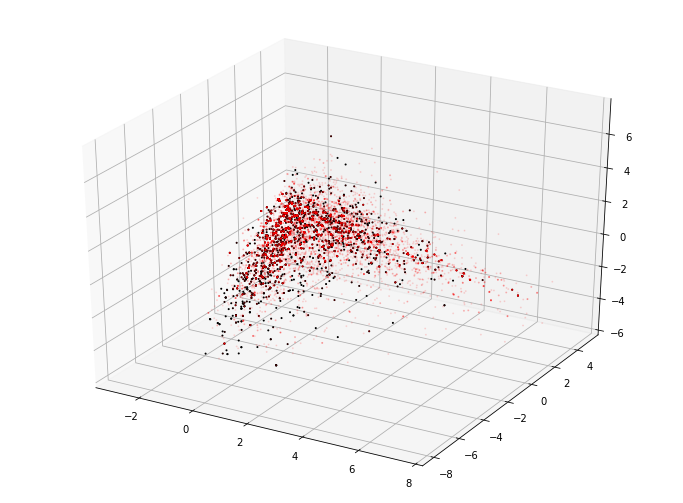

In [10]:
X_ = data_genres_me
X_ = X_.drop(['anime_id', 'label'], axis=1)
X_ = X_.reset_index(drop=True)
X_ = X_.astype(float)
X_ = np.array(X_)
# Для начала отмасштабируем выборку
rows, cols = X_.shape

# центрирование - вычитание из каждого значения среднего по столбцу
means = X_.mean(0)
for i in range(rows):
    for j in range(cols):
        X_[i, j] -= means[j]

# деление каждого значения на стандартное отклонение
std = np.std(X_, axis=0)
for i in range(cols):
    for j in range(rows):
        X_[j][i] /= std[i]
        
# Найдем собственные векторы и собственные значения (англ. Eigenvalues)
covariance_matrix = X_.T.dot(X_)
eig_values, eig_vectors = np.linalg.eig(covariance_matrix)
# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]
# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)    
eig_sum = sum(eig_values)
# Доля дисперсии, описываемая каждой из компонент
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
# Кумулятивная доля дисперсии по компонентам
cum_var_exp = np.cumsum(var_exp)
print('Кумулятивная доля дисперсии по компонентам', cum_var_exp)
# Сформируем вектор весов из собственных векторов, соответствующих первым двум главным компонентам
W = np.hstack((eig_pairs[0][1].reshape(cols,1), eig_pairs[1][1].reshape(cols,1), eig_pairs[2][1].reshape(cols,1)))
# print(f'Матрица весов W:\n', W)
Z = X_.dot(W)
y = label

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize = (12, 9))
ax = fig.add_subplot(111, projection='3d')

for c, i, s, t in zip("rk", [0, 1], [1, 1], [0.1, 1]):
    ax.scatter(Z[y == i, 0], Z[y == i, 1], Z[y == i, 2], c=c, s=s, alpha=t)

plt.show()

In [12]:
data_genres_me['label'] = label
data_genres_me.to_csv('data_genres_after_PU_learning.csv')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y = data_genres_me['label']
x = data_genres_me.drop(['label', 'anime_id'], axis=1)

knc = KNeighborsClassifier(n_neighbors=50)
knc.fit(x, y)